In [ ]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

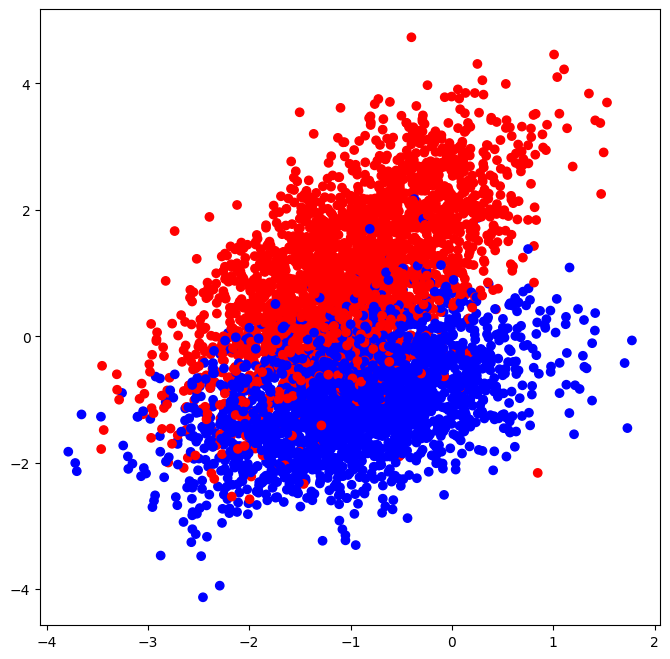

In [ ]:
# сгенерируем данные, представляющие собой 500 объектов с 2-мя признаками
classification_data, classification_labels = datasets.make_classification(n_samples=5000,
                                                      n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1, random_state=23)

# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors);

In [ ]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []

    for i in range(N):
        b_data = data.copy()
        b_labels = labels.copy()

        subsample_indices = get_subsample(n_samples)
        change_indices = get_subsample(n_samples)

        #for idx in range(len(subsample_indices)):
        b_data[change_indices] = data[subsample_indices]
        b_labels[change_indices] = labels[subsample_indices]

        bootstrap.append((b_data, b_labels))

    return bootstrap

In [ ]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]

    len_subsample = int(np.sqrt(len_sample))
    subsample = []

    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())

    return subsample


In [ ]:
class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [ ]:
class Leaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred

    def predict(self):
        dict = {}

        for classes in self.labels:
            if dict.get(classes) == None:
                dict[classes] = 1
            else:
                dict[classes] += 1

        mx = 0
        cls = -100

        for classes in dict.keys():
            if mx < dict[classes]:
                mx = dict[classes]
                cls = classes

        return cls

def gini(labels):
    dict = {}

    n = len(labels)

    for classes in labels:
        if dict.get(classes) == None:
            dict[classes] = 1
        else:
            dict[classes] += 1

    impurity = 0

    for classes in dict.keys():
        prob = dict[classes] / n
        impurity += prob * (1 - prob)

    return impurity

def quality(left_labels, right_labels, current_gini):
    n = len(left_labels)
    m = len(right_labels)

    return current_gini - gini(left_labels) * (n / (n + m)) - gini(right_labels) * (m / (n + m))

def split(data, labels, index, t):
    condition = data[:, index] >= t

    true_data = data[condition]
    false_data = data[~condition]

    true_labels = labels[condition]
    false_labels = labels[~condition]

    return true_data, false_data, true_labels, false_labels

def find_best_split(data, labels):
    best_quality = 0
    best_t = 0
    best_index = -1

    current_gini = gini(labels)

    for index in range(data.shape[1]):
        unique_values = set(data[:, index])

        for t in unique_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            q = quality(true_labels, false_labels, current_gini)

            if q > best_quality:
                best_quality = q
                best_t = t
                best_index = index

    return current_gini - best_quality, best_t, best_index

def build_tree(data, labels):
    min_split = 10
    best_quality, best_t, best_index = find_best_split(data, labels)
    true_data, false_data, true_labels, false_labels = split(data, labels, best_index, best_t)

    if best_quality == 0:
        return Leaf(data, labels)

    if len(true_data) >= min_split:
        true_branch = build_tree(true_data, true_labels)
    else:
        true_branch = Leaf(true_data, true_labels)

    if len(false_data) >= min_split:
        false_branch = build_tree(false_data, false_labels)
    else:
        false_branch = Leaf(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева

    return Node(best_index, best_t, true_branch, false_branch)

def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)

    for boot in bootstrap:
        forest.append(build_tree(boot[0], boot[1]))

    return forest

def classify_object(obj, node):
    if isinstance(node, Leaf):
        return node.prediction

    if obj[node.index] < node.t:
        return classify_object(obj, node.false_branch)

    return classify_object(obj, node.true_branch)

def predict(data, tree):
    ans = []
    for obj in data:
        ans.append(classify_object(obj, tree))

    return ans

def tree_vote(forest, data):
    voted_predictions = []
    d = []

    for _ in range(len(data)):
        d.append({})

    for tree in forest:
        pred = predict(data, tree)

        for i in range(len(pred)):
            if d[i].get(pred[i]) == None:
                d[i][pred[i]] = 1
            else:
                d[i][pred[i]] += 1

    for diction in d:
        #print(diction)
        mx = -1
        cls = -100

        for classes in diction.keys():
            if mx < diction[classes]:
                mx = diction[classes]
                cls = classes

        voted_predictions.append(cls)

    return voted_predictions

In [ ]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                     classification_labels,
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [ ]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
      if actual[i] == predicted[i]:
        correct += 1
    return correct / float(len(actual)) * 100.0

In [ ]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_1, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 95.143
Точность случайного леса из 1 деревьев на тестовой выборке: 83.600


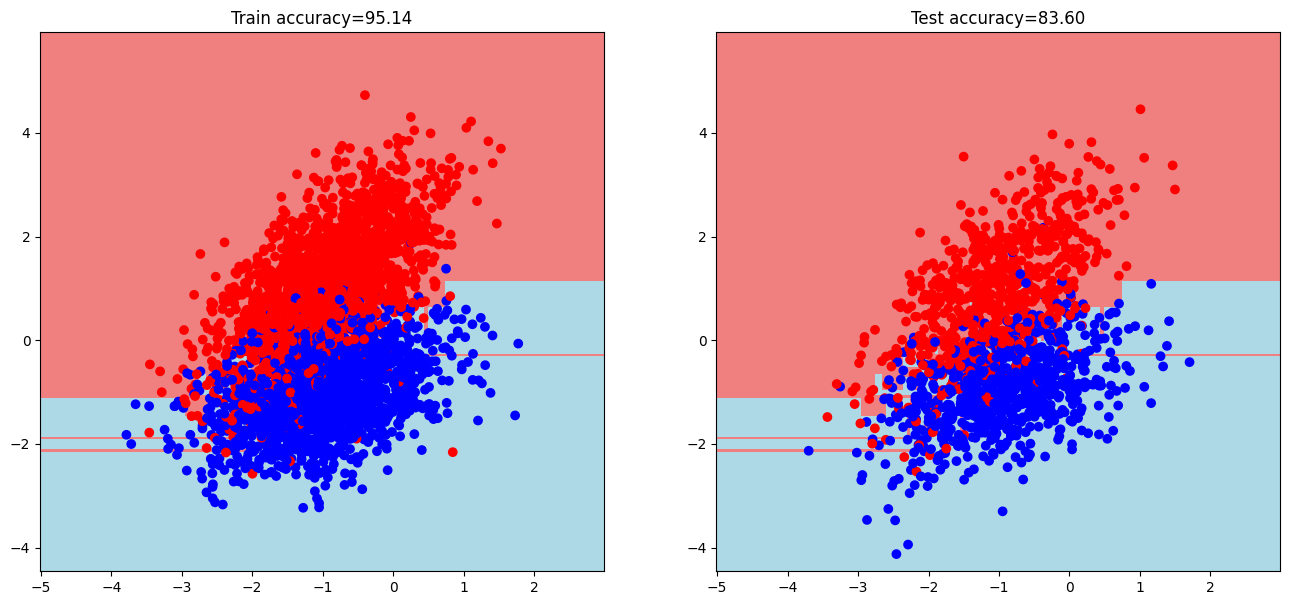

In [ ]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()

In [ ]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_3, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 96.029
Точность случайного леса из 3 деревьев на тестовой выборке: 84.867


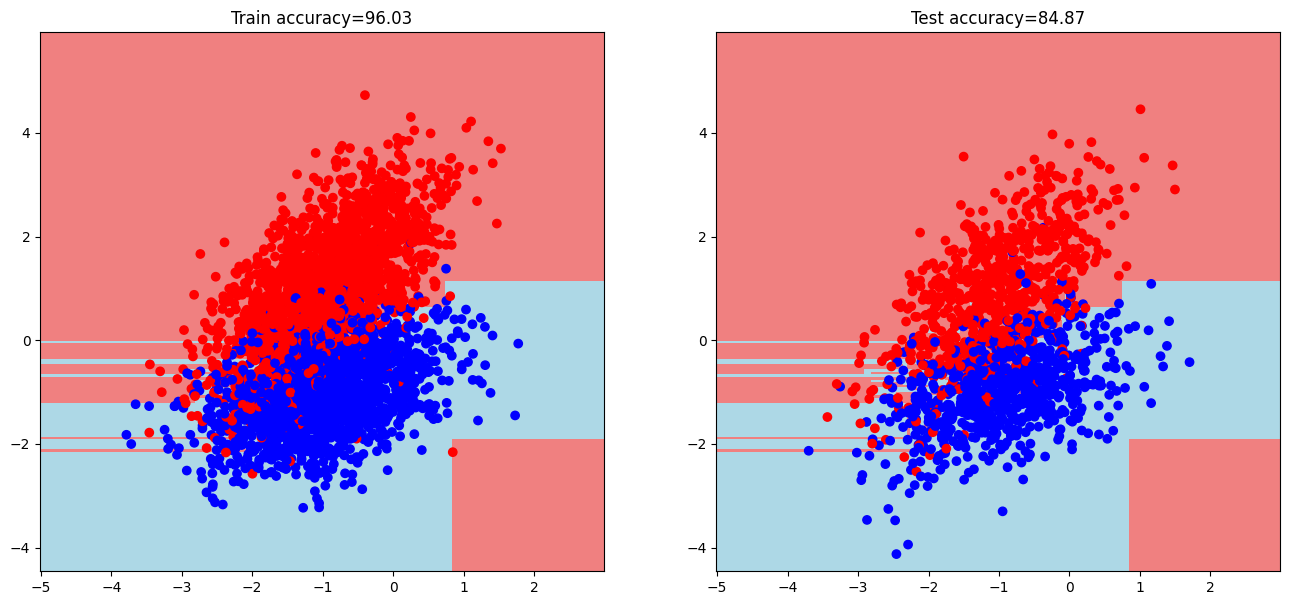

In [ ]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_3, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()


In [ ]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_10, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 96.229
Точность случайного леса из 10 деревьев на тестовой выборке: 85.533


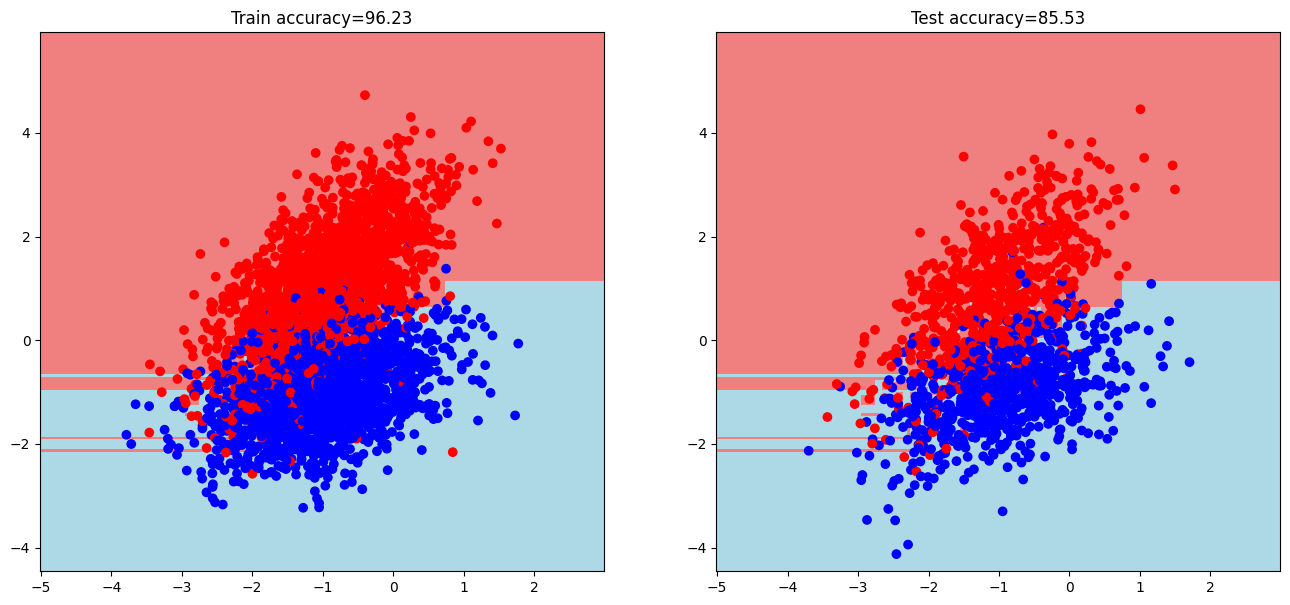

In [ ]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_10, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()

In [ ]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_50, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 96.343
Точность случайного леса из 50 деревьев на тестовой выборке: 85.600


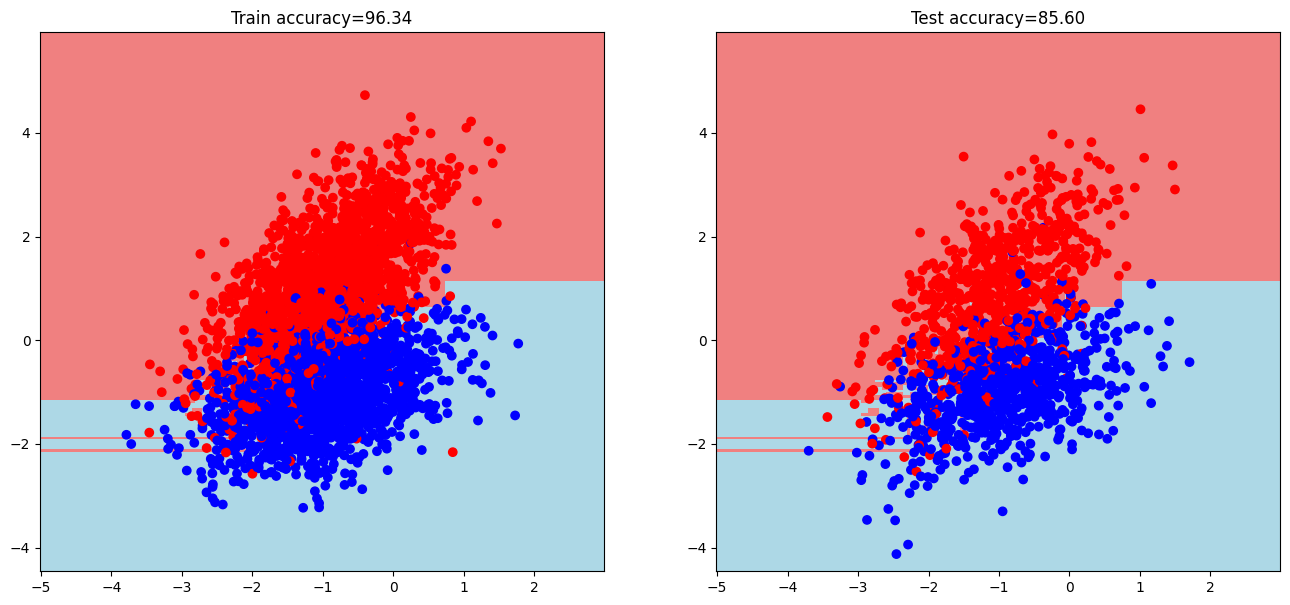

In [ ]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_50, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()